In [62]:
import requests
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

Função para extrair as colunas, conforme a tabela no AWS Glue

In [2]:
def get_clean(json_raw):
    clean = {
        'id': json_raw['id'],
        'name': json_raw['name'],
        'abv': json_raw['abv'],
        'ibu': json_raw['ibu'],
        'target_fg': json_raw['target_fg'],
        'target_og': json_raw['target_og'],
        'ebc': json_raw['ebc'],
        'srm': json_raw['srm'],
        'ph': json_raw['ph']
    }
    return clean

Requisições para coleta dos dados da API e transformação em Dataframe

In [3]:
url = 'https://api.punkapi.com/v2/beers?page={page}&per_page=50'

In [4]:
beers = []
n_pages = 20
for idx in range(1, n_pages+1):
    r = requests.get(url.format(page=idx))
    beers.append(list(map(get_clean, r.json())))

In [5]:
beers_clean = np.concatenate(beers).ravel().tolist()

In [6]:
beers_df = pd.DataFrame(beers_clean)
beers_df.drop(columns=['id', 'name'], inplace=True)
beers_df.dropna(inplace=True)
beers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 324
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   abv        315 non-null    float64
 1   ibu        315 non-null    float64
 2   target_fg  315 non-null    float64
 3   target_og  315 non-null    float64
 4   ebc        315 non-null    float64
 5   srm        315 non-null    float64
 6   ph         315 non-null    float64
dtypes: float64(7)
memory usage: 19.7 KB


Uma pequena análise dos dados, com suas descrições e correlações

In [7]:
beers_df.describe()

,abv,ibu,target_fg,target_og,ebc,srm,ph
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,7.750159,65.447619,1015.317460,1067.307619,66.682222,33.608317,4.659048
std,3.895946,92.876783,14.649651,27.097993,92.765522,46.763569,4.217035
min,0.500000,0.000000,1000.000000,1007.000000,2.000000,1.000000,3.200000
25%,5.200000,35.000000,1010.000000,1048.250000,15.000000,8.000000,4.400000
50%,7.200000,50.000000,1012.000000,1065.000000,30.000000,15.000000,4.400000
75%,9.000000,70.000000,1015.000000,1079.500000,74.900000,38.000000,4.400000
max,41.000000,1157.000000,1125.000000,1157.000000,600.000000,305.000000,79.000000


,abv,ibu,target_fg,target_og,ebc,srm,ph
abv,1.000000,0.625721,0.258767,0.725155,0.408687,0.408931,0.024957
ibu,0.625721,1.000000,0.048908,0.252590,0.122521,0.123257,0.004733
target_fg,0.258767,0.048908,1.000000,-0.109582,0.364526,0.364052,0.004423
target_og,0.725155,0.252590,-0.109582,1.000000,0.437241,0.437389,0.047247
ebc,0.408687,0.122521,0.364526,0.437241,1.000000,0.999521,-0.015814
srm,0.408931,0.123257,0.364052,0.437389,0.999521,1.000000,-0.015591
ph,0.024957,0.004733,0.004423,0.047247,-0.015814,-0.015591,1.000000


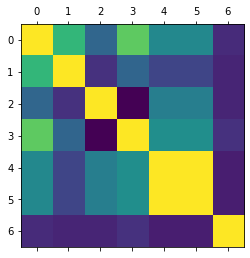

In [11]:
#beers_df.hist(bins=50, figsize=(20,15))
#plt.show()
display(beers_df.corr())
plt.matshow(beers_df.corr())
plt.show()

Como são poucos os atributos e não possuem alta correlação, todos serão levados para o treinamento dos modelos

In [276]:
y = beers_df['ibu'].copy()
X = beers_df.drop(columns=['ibu']).copy()

Separação em dados de teste e treino

In [277]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Verificando a possibilidade de existirem atributos mais relevantes que outros.
Como não houve exclusão de nenhum, continuaremos com todos

In [278]:
from sklearn.feature_selection import SelectKBest, f_regression

X_new = SelectKBest(f_regression, k='all').fit_transform(X_train, y_train)
print(X_train.shape, X_new.shape)

(252, 6) (252, 6)


Como visto na pequena análise feita acima, os atributos estão em escalas muito diferentes.
Isso pode prejudicar a performance de alguns algoritmos, dessa forma todos serão padronizados

In [279]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [280]:
X_train_scaled = scaler.transform(X_train)

Função que retorna a média e o desvio padrão para os 5 folds da validação cruzada, utilizando como função a raiz do erro quadrado médio

In [281]:
def get_score(regressor, X, y):
    scores = cross_val_score(reg, X_train_scaled, y_train, scoring="neg_root_mean_squared_error", cv=5)
    rmse_scores = -scores
    return rmse_scores.mean(), rmse_scores.std()

Modelo mais simples de Regressão Linear com regularização que serve como baseline

In [282]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet(random_state=42)
#reg.fit(X_train_scaled, y_train)

print(get_score(reg, X_train_scaled, y_train))

(77.49899903109909, 43.141738560724505)


Modelo SVM. Como possui muitos parâmetros é um bom candidato para a próxima etapa, mesmo com um score menor que o anterior

In [283]:
from sklearn.svm import SVR

reg = SVR()
#reg.fit(X_train_scaled, y_train)

print(get_score(reg, X_train_scaled, y_train))

(82.21002414169634, 61.54186999918029)


Modelo RandomForest. Possui muitos parâmetros e sofre com overfitting. Dessa forma, o resultado pode não ser confiável. É necessário passar pela próxima etapa

In [284]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=42)
#reg.fit(X_train_scaled, y_train)

print(get_score(reg, X_train_scaled, y_train))

(49.675069728438636, 22.677088335716086)


Modelo XGBoost. Assim como o modelo anterior, possui muitos parâmetros. Portanto passará pela próxima etapa

In [285]:
from xgboost import XGBRegressor

reg = XGBRegressor(random_state=42)

print(get_score(reg, X_train_scaled, y_train))

(34.717146328880034, 5.443109013429761)


Será realizada uma busca aleatória nos parâmetros dos modelos mais complexos, associado a validação cruzada. Assim, podemos conseguir valores para os parâmetros que tenham uma boa relação entre Bias e Variância

In [286]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=2, high=6),
        'max_depth': randint(low=3, high=10)
    }

forest_reg = RandomForestRegressor(random_state=42)
r_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=100, cv=5, 
                              scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

r_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002548CED3940>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002548C8F8C10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002548DC7B550>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [287]:
r_search.best_estimator_

RandomForestRegressor(max_depth=3, max_features=5, n_estimators=14,
                      random_state=42)

In [288]:
param_distribs = {'C': sp.stats.expon(scale=1000), 'gamma': sp.stats.expon(scale=.1), 'kernel': ['rbf', 'linear']}

svm_reg = SVR()
r_search = RandomizedSearchCV(svm_reg, param_distribs, n_iter=100, cv=5, 
                              scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

r_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002548DC39BB0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002548D8CA100>,
                                        'kernel': ['rbf', 'linear']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [289]:
r_search.best_estimator_

SVR(C=2373.312770663391, gamma=0.03176359085304841)

In [290]:
param_distribs = {'n_estimators': randint(low=1, high=200), 'gamma': sp.stats.expon(scale=10),
                  'max_depth': randint(low=3, high=10), 'reg_lambda': sp.stats.expon(scale=1),
                  'reg_alpha': sp.stats.expon(scale=1)}

xgb_reg = XGBRegressor(random_state=42)
r_search = RandomizedSearchCV(xgb_reg, param_distribs, n_iter=100, cv=10, 
                              scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

r_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100,...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002548DCC6040>,
                                        'n_estimators': <scipy

In [291]:
r_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1.5416196746656106,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.05806520264207262, reg_lambda=1.280129748994866,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Com base nos resultados da busca aleatória. Treinamos os melhores modelos e verificamos seu score nas bases de treino e teste

In [292]:
best_forest = RandomForestRegressor(max_depth=3, max_features=5, n_estimators=14, random_state=42)
best_forest.fit(X_train_scaled, y_train)

y_train_best_forest = best_forest.predict(X_train_scaled)
y_test_best_forest = best_forest.predict(scaler.transform(X_test))

print('Train', np.sqrt(mean_squared_error(y_train_best_forest, y_train)))
print('Test', np.sqrt(mean_squared_error(y_test_best_forest, y_test)))

Train 35.833448491289765
Test 24.799638602661346


In [293]:
best_svm = SVR(C=2373.312770663391, gamma=0.03176359085304841)
best_svm.fit(X_train_scaled, y_train)

y_train_best_svm = best_svm.predict(X_train_scaled)
y_test_best_svm = best_svm.predict(scaler.transform(X_test))

print('Train', np.sqrt(mean_squared_error(y_train_best_svm, y_train)))
print('Test', np.sqrt(mean_squared_error(y_test_best_svm, y_test)))

Train 38.49500422652386
Test 20.209218365008667


In [296]:
best_xgb = XGBRegressor(gamma=1.5416196746656106, max_depth=5, n_estimators=15,
                        reg_alpha=0.05806520264207262, reg_lambda=1.280129748994866, random_state=42)
best_xgb.fit(X_train_scaled, y_train)

y_train_best_xgb = best_xgb.predict(X_train_scaled)
y_test_best_xgb = best_xgb.predict(scaler.transform(X_test))

print('Train', np.sqrt(mean_squared_error(y_train_best_xgb, y_train)))
print('Test', np.sqrt(mean_squared_error(y_test_best_xgb, y_test)))

Train 17.317697857689858
Test 20.71206490177419


O modelo escolhido é aquele que consegue generalizar melhor, sem se sobreajustar ao treinamento. Os dois primeiros modelos provavelmente não conseguiram convergir, devido ao erro de treinamento mais alto que o de teste, portanto o último modelo será o escolhido, visto que possui o menor erro de teste.

XGBRegressor(gamma=1.5416196746656106, max_depth=5, n_estimators=15,
                        reg_alpha=0.05806520264207262, reg_lambda=1.280129748994866, random_state=42)